This script detects the personal experiences in unsupervised data from social media based on supervised data. The second class performs topic modelling on this data. 

For determining the number of topics, the max of the TC-W2V can be used (this is the default) but a graph of the coherence values is also provided for manual evaluation.

--author-- AR Dirkson
--date-- 4-2-2019

As presented in : 
Dirkson, Anne; Verberne, Suzan & Kraaij, Wessel. Narrative Detection in online patient communities. ECIR Text2Story. 

Topic modelling based on the tutorial by Derek Greene: 
https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

Topic coherence, measured using TC-W2V, was used to select the number of topics.

O’Callaghan,    D.,    Greene,    D.,    Carthy,    J.,    Cunningham,    P.:    Ananalysisofthecoherenceofdescriptorsintopicmodeling.ExpertSystemswithApplications42(13),5645–5657(2015).https://doi.org/10.1016/J.ESWA.2015.02.055

---------------------------------------------


The input: 
  
Both the training data and the unsupervised data should be a pandas dataframe. Unsupervised data should have a column with strings called Post. Training data should also have column with strings called Post and one with labels called Label.  

Note: you will need to change the paths to the right files in the script.

In [48]:
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pandas as pd 
import pickle

import numpy as np
import warnings

warnings.filterwarnings (action = 'ignore')

from collections import defaultdict, Counter

from nltk import word_tokenize

import pprint

from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.decomposition import NMF

from itertools import combinations

import matplotlib.pyplot as plt

import gensim

In [31]:
class NarrativeFilter (): 
    
    def __init__(self): 
        pass 
    
    def load_obj(self, name):
        with open(name + '.pkl', 'rb') as f:
            return pickle.load(f, encoding='latin1')
        
    def train_data (self, train_data): 
        X = train_data['Post']
        y = train_data['Label']

        vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (3,3))

        ngrams_train = vectorizer.fit_transform(X)

        ngrams_train_df = pd.DataFrame (ngrams_train.toarray())

        svc_char = LinearSVC (C = 0.0001)
        svc_char.fit (ngrams_train_df, y)
        return vectorizer, svc_char
        
    def filtr(self): 
        #load the training data 
        train_data = self.load_obj ('C:/Users/dirksonar/Documents/Data/Project2_nardetect/experience_classifier/obj/share_exp_data')
        data = self.load_obj ('C:/Users/dirksonar/Documents/Data/Project2_nardetect/experience_classifier/unsupervised/obj/unsupervised_data_df')
        
        posts= data['Post']
        vectorizer, svc_char = self.train_data (train_data)
        ngrams_unsupervised = vectorizer.transform(posts)
        y_pred = svc_char.predict (ngrams_unsupervised)
        outcome_df = pd.DataFrame(y_pred, columns = ['Predicted'])
        
        #transform the output
        unsup_out_df = pd.concat ([data, outcome_df], axis =1)
        
        #filter out the non-narratives 
        unsup_pos = unsup_out_df[unsup_out_df['Predicted'] == 1]

        unsup_pos.rename (columns = {'Predicted':'Label'}, inplace = True)

        print(unsup_pos.head())
        
        #filter the supervised data
        sup_pos = train_data[train_data['Label'] ==1]
        
        return unsup_pos, sup_pos
        

In [49]:
class TopicModeller (): 
    
    def __init__(self): 
        self.stop_words =set(stopwords.words('english')) 
       
        
    def preprocess_data(self, posts):
        posts2 = [word_tokenize (m) for m in posts]
        
        posts3 = []

        for p in posts2: 
            p2 = [w for w in p if not w in self.stop_words] 
            posts3.append (p2)
        
        t = TreebankWordDetokenizer()
        posts4 = [t.detokenize (m) for m in posts3]

        tfidf_vectorizer = TfidfVectorizer()

        tfidf = tfidf_vectorizer.fit_transform(posts4)
        terms = tfidf_vectorizer.get_feature_names()
        
        w2v_model = gensim.models.Word2Vec(posts3, size=400, min_count=2, sg=1)
        
        return w2v_model, terms, tfidf
    
        
    def calculate_coherence(self, w2v_model, term_rankings ):
        overall_coherence = 0.0
        for topic_index in range(len(term_rankings)):
            # check each pair of terms
            pair_scores = []
            for pair in combinations( term_rankings[topic_index], 2 ):
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            # get the mean for all pairs in this topic
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
        # get the mean score across all topics
        return overall_coherence / len(term_rankings)

    def get_descriptor(self, all_terms, H, topic_index, top ):
        # reverse sort the values to sort the indices
        top_indices = np.argsort( H[topic_index,:] )[::-1]
        # now get the terms corresponding to the top-ranked indices
        top_terms = []
        for term_index in top_indices[0:top]:
            top_terms.append( all_terms[term_index] )
        return top_terms

    def calculate_topic_number (self,w2v_model, tfidf, terms):

        kmin, kmax = 4, 15         #this is the k range for which we will calculate but this can be altered
        topic_models = []

        # try each value of k
        for k in range(kmin,kmax+1):
            print("Applying NMF for k=%d ..." % k )
            # run NMF
            model = NMF( init="nndsvd", n_components=k ) 
            W = model.fit_transform(tfidf)
            H = model.components_    
            # store for later
            topic_models.append( (k,W,H) )
            
        #compare the coherence of each set
    
        k_values = []
        coherences = []
        for (k,W,H) in topic_models:
            # Get all of the topic descriptors - the term_rankings, based on top 10 terms
            term_rankings = []
            for topic_index in range(k):
                term_rankings.append( self.get_descriptor(terms, H, topic_index, 10 ) )
            # Now calculate the coherence based on our Word2vec model
            k_values.append( k )
            coherences.append(self.calculate_coherence( w2v_model, term_rankings ) )
            print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

        fig = plt.figure(figsize=(13,7))
        # create the line plot
        ax = plt.plot( k_values, coherences )
        plt.xticks(k_values)
        plt.xlabel("Number of Topics")
        plt.ylabel("Mean Coherence")
        # add the points
        plt.scatter( k_values, coherences, s=120)
        # find and annotate the maximum point on the plot
        ymax = max(coherences)
        xpos = coherences.index(ymax)
        best_k = k_values[xpos]
        plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
        # show the plot
        plt.show()     
            
        m = coherences.index (max(coherences))
        topic_number= k_values[m]
        return topic_number
    
    
    def print_top_words(self, model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            message = "Topic #%d: " % topic_idx
            message += " ".join([feature_names[i]
                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
        print()
    
    def extract_topics (self, data): 
        w2v_model, terms, tfidf = self.preprocess_data (data)
        n_top_words = 20 #this can be altered - it is the number of words for each topic you return
        
        number_topics = self.calculate_topic_number (w2v_model, tfidf, terms)
        n_components = number_topics
        
        # Fit the NMF model
        nmf = NMF(n_components=n_components, random_state=1,
                  alpha=.1, l1_ratio=.5).fit(tfidf)

        print("\nTopics in NMF model (Frobenius norm):")
        self.print_top_words(nmf, terms, n_top_words)
    
    

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
K=04: Coherence=0.5506
K=05: Coherence=0.5744
K=06: Coherence=0.5780
K=07: Coherence=0.6220
K=08: Coherence=0.6121
K=09: Coherence=0.6044
K=10: Coherence=0.6134
K=11: Coherence=0.6149
K=12: Coherence=0.6187
K=13: Coherence=0.6255
K=14: Coherence=0.6262
K=15: Coherence=0.6148


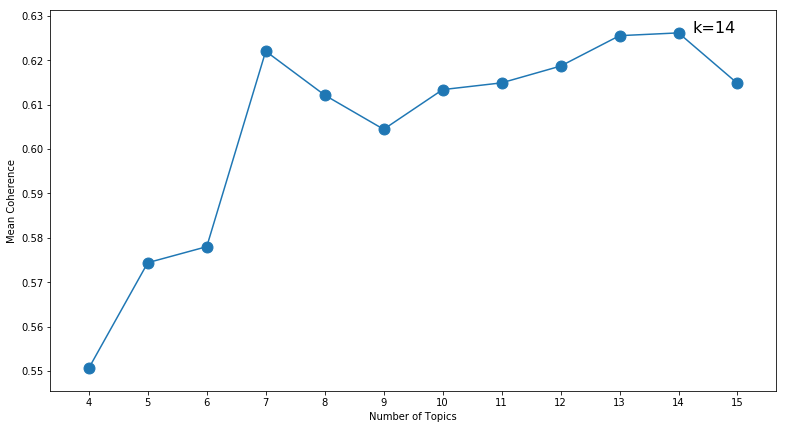


Topics in NMF model (Frobenius norm):
Topic #0: get time one like know back would day work well much feel pain going better days go also got really
Topic #1: imatinib taking year started adjuvant 400mg since months stopped working stop hair anyone back month 11 long exon 800mg drug
Topic #2: years ago almost 10 two still three 12 later 13 11 husband scans free recurrence many diagnosis imatinib 14 five
Topic #3: scan months ct every scans pet results year next clear last mri showed first cat three month today chest another
Topic #4: gist tumor removed small diagnosed liver cm mitotic rate found cancer intestine size primary surgeon one told specialist remove husband
Topic #5: side effects effect fatigue different eyes bad time everyone minimal months 400mg puffy imatinib diarrhea easier nausea people diminish almost
Topic #6: stomach removed liver tumor part spleen metastases cm pain attached pancreas wall esophagus mine along outside resection 12 remove took
Topic #7: surgery remove 

In [50]:
#example script for running the classes

unsup_pos, sup_pos = NarrativeFilter().filtr()
print(unsup_pos.head())
print(sup_pos.head())

#combine the training and unsupervised data
full_pos_text = list(sup_pos['Post'])
[full_pos_text.append(m) for m in list(unsup_pos['Post'])]

TopicModeller().extract_topics(full_pos_text)